Сначала построим нашу модель.

In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv('orange_small_churn_train_data.csv', index_col = 0)

In [3]:
numeric_columns = np.array(train.columns[:190])
categorical_columns = np.array(train.columns[190:230])

In [4]:
not_null_numeric_columns = np.array(numeric_columns[np.array(pd.notnull(train[numeric_columns]).any())])
not_null_categorical_columns = np.array(categorical_columns[np.array(pd.notnull(train[categorical_columns]).any())])

In [5]:
train_numeric = train[not_null_numeric_columns]
train_categorical = train[not_null_categorical_columns]
y_train = train['labels']

In [6]:
train_numeric = train_numeric.fillna(train_numeric.mean(0), axis = 0)
train_categorical = train_categorical.fillna('NA')

In [7]:
for var in not_null_categorical_columns:
    value_counts = train_categorical[var].value_counts()
    train_categorical[var] = np.array([value_counts[x] for x in train_categorical[var]])

In [8]:
X_train = pd.concat([train_numeric, train_categorical], axis = 1)

In [9]:
from sklearn.feature_selection import VarianceThreshold
X_train = VarianceThreshold().fit_transform(X_train)

In [10]:
from sklearn.feature_selection import SelectKBest
X_train = SelectKBest(k = 40).fit_transform(X_train, y_train)

In [11]:
import xgboost as xgb
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)
y_predictions = xgb_clf.predict(X_train)
y_probabilities = xgb_clf.predict_proba(X_train)[:, 1]

Выберем только тех пользователей, которых наша модель предсказала как склонных к оттоку, и запишем в переменную `true_values` настоящие ответы на этих пользователях.

In [12]:
labels = pd.DataFrame({'prediction' : y_predictions, 'probability' : y_probabilities, 'true_value' : np.array(y_train)})

In [13]:
churn_predicted = labels[labels.prediction == 1].sort_values('probability', ascending = False).reset_index(drop = True)

In [14]:
true_values = np.array(churn_predicted.true_value)

Введём следующие параметры:
- количество денег, которое в среднем приносит один пользователь в месяц = 1000
- количество денег, которое в среднем мы будем вкладывать в удержание одного пользователя = 100
- вероятность, с которой пользователь примет наше предложение = 0.3
- количество пользователей, которое будет участвовать в кампании = топ 25% пользователей, склонных к оттоку согласно модели

1\. Введите еще несколько параметров и на их основе постройте простую экономическую модель: формулу по которой в зависимости от значения исходных параметров вы сможете рассчитать экономический эффект от проведения кампании (= сколько денег вы получили (или наоборот потеряли) от проведения кампании по удержанию) с использование вашей модели.

Построим формулу для подсчёта экономического эффекта.

\begin{equation*}
\text{effect} = \text{number of accepted} \times \text{ARPU} - \text{number of users} \times \text{retention cost}
\end{equation*}

Здесь
effect - экономический эффект,
number of accepted - количество пользователей, действительно склонных к оттоку, которые примут наше предложение,
ARPU - количество денег, которое в среднем приносит один пользователь в месяц,
number of users - количество пользователей, которое будет участвовать в кампании,
retention cost - количество денег, которое в среднем мы будем вкладывать в удержание одного пользователя.

In [21]:
def effect(arpu, retention_cost, probability, top):
    number_of_users = int(np.floor(top * len(true_values)))
    number_of_churned = sum(true_values[:number_of_users] == 1)
    number_of_accepted = int(np.floor(probability * number_of_churned))
    cost = number_of_users * retention_cost
    income = number_of_accepted * arpu
    return income - cost

In [22]:
effect(1000, 100, 0.3, 0.25)

2100

При заданных параметрах экономический эффект равен 2100.

2\. Исходя из введенных параметров проанализируйте, какой топ пользователей, склонных к оттоку согласно модели, оптимально выбрать для проведения кампании по удержанию для таким образом, чтобы экономический эффект был наибольшим?

In [23]:
effects = np.array([[effect(1000, 100, 0.3, top), top] for top in np.arange(0, 1.01, 0.01)])
effects[effects[:, 0].argsort()][-1]

array([  9.40000000e+03,   9.90000000e-01])

Оптимальный топ - 99%. Экономический эффект при нём равен 9400.

3\. Попробуйте усложнить экономическую модель. Добавьте еще несколько параметров и поиграйте с ними (например, измените стоимость удержания и вероятность, с которой пользователь принимает предложение), проанализируйте как меняется оптимальный размер топа?

Введём ещё один дополнительный параметр time - количество времени, на которое нам в среднем удастся удержать клиента, если он примет наше предложение = 3 месяца.

Тогда формула для подсчёта экономического эффекта примет вид

\begin{equation*}
\text{effect} = \text{number of accepted} \times \text{ARPU} \times \text{time} - \text{number of users} \times \text{retention cost}
\end{equation*}

In [24]:
def effect(arpu, retention_cost, probability, top, time):
    number_of_users = int(np.floor(top * len(true_values)))
    number_of_churned = sum(true_values[:number_of_users] == 1)
    number_of_accepted = int(np.floor(probability * number_of_churned))
    cost = number_of_users * retention_cost
    income = number_of_accepted * arpu * time
    return income - cost

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

Построим график изменения оптимального размера топа в зависимости от стоимости удержания.

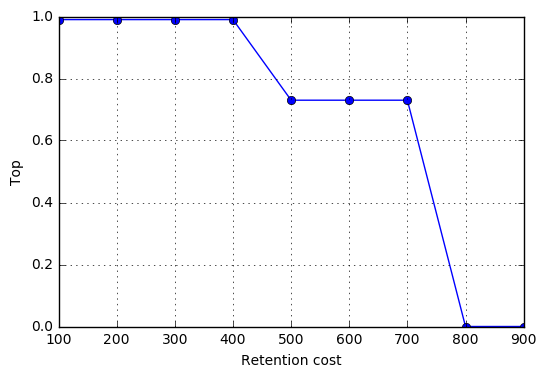

In [28]:
retention_costs = np.arange(100, 1000, 100)
tops = []
for retention_cost in retention_costs:
    effects = np.array([[effect(1000, retention_cost, 0.3, top, 3), top] for top in np.arange(0, 1.01, 0.01)])
    tops.append(effects[effects[:, 0].argsort()][-1][1])
tops = np.array(tops)
plt.figure()
plt.xlabel('Retention cost')
plt.ylabel('Top')
plt.grid()
plt.plot(retention_costs, tops, 'o-')
plt.show()

Видим, что чем выше стоимость удержания, тем меньше оптимальный размер топа, что логично.

Построим график изменения оптимального размера топа в зависимости от вероятности, с которой пользователь принимает предложение.

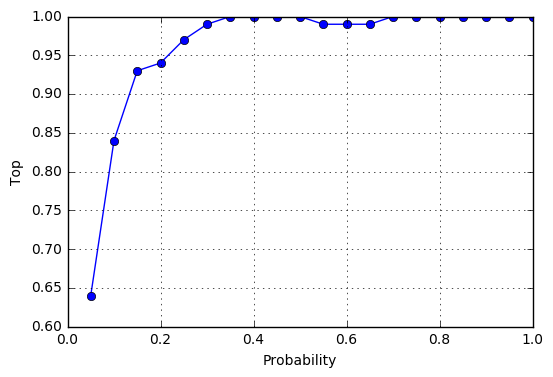

In [29]:
probabilities = np.arange(0.05, 1.05, 0.05)
tops = []
for probability in probabilities:
    effects = np.array([[effect(1000, 100, probability, top, 3), top] for top in np.arange(0, 1.01, 0.01)])
    tops.append(effects[effects[:, 0].argsort()][-1][1])
tops = np.array(tops)
plt.figure()
plt.xlabel('Probability')
plt.ylabel('Top')
plt.grid()
plt.plot(probabilities, tops, 'o-')
plt.show()

Видим, что чем выше вероятность, с которой пользователь принимает предложение, тем больше оптимальный размер топа, что логично.

4\. Всегда ли применение модели экономически оправданно? Приведите пример набора значений параметров, при которых применение модели перестает быть оправданным.

Нет, не всегда. Применение модели не оправдано, когда доход с одного пользователя низкий (к примеру, 500), а стоимость удержания высокая (к примеру, 1000).

In [33]:
effect(500, 1000, 0.3, 0.25, 3)

-13000

Видим, что экономический эффект при этом уходит в минус, т.е. затраты становятся больше, чем доходы.

5\. Оцените изменение экономического эффекта от проведения кампании по удержанию при увеличении качества модели на 1%? На 3%? При ответе на вопрос укажите, по какой метрике вы оцениваете качество.

Будем оценивать качество по метрике precision. Посчитаем её вручную, как количество true positives, разделённое на количество positives.

In [34]:
true_positives_original = sum(true_values == 1)
positives = len(true_values)
precision = float(true_positives_original)/positives
print 'True positives: ', true_positives_original
print 'Positives: ', positives
print 'Precision: ', precision

True positives:  58
Positives:  77
Precision:  0.753246753247


Увеличивая качество модели, будем считать, что количество positives остаётся прежним, а количество true positives увеличивается.

In [35]:
true_positives_one_percent = int(round((precision * 1.01) * positives))
print 'True positives при увеличении качества на 1%: ', true_positives_one_percent

True positives при увеличении качества на 1%:  59


In [36]:
true_positives_two_percent = int(round((precision * 1.02) * positives))
print 'True positives при увеличении качества на 2%: ', true_positives_two_percent

True positives при увеличении качества на 2%:  59


In [37]:
true_positives_three_percent = int(round((precision * 1.03) * positives))
print 'True positives при увеличении качества на 3%: ', true_positives_three_percent

True positives при увеличении качества на 3%:  60


Для удобства подсчёта введём новую формулу для расчёта экономического эффекта, в которой будем считать, что мы всегда берём топ 100% пользователей, склонных к оттоку согласно модели.

In [38]:
def effect_2(arpu, retention_cost, probability, time, true_positives):
    number_of_accepted = int(np.floor(probability * true_positives))
    cost = positives * retention_cost
    income = number_of_accepted * arpu * time
    return income - cost

Посчтитаем экономический эффект для оригинальной модели и моделей, качество которых увеличено на 1%, 2% и 3%.

In [39]:
for true_positives in (true_positives_original, true_positives_one_percent, true_positives_two_percent,
                       true_positives_three_percent):
    print true_positives, ':', effect_2(1000, 100, 0.3, 3, true_positives)

58 : 43300
59 : 43300
59 : 43300
60 : 46300


Видим, что при увеличении качества модели на 1% и 2% экономический эффект остаётся прежним, а при увеличении на 3% увеличивается на 3000.

6\. Как вы думаете, является ли экономически оправданным вложение средств в улучшение качества модели? На сколько нужно улучшить модель, чтобы это качественно сказалось на экономическом эффекте от удержания?

Вложение средств в увеличение качества модели является экономически оправданным, если увеличение экономического эффекта больше, чем количество средств, которое мы вкладываем. Как показал эксперимент выше, качество модели нужно увеличить хотя бы на 3%, чтобы это сказалось на экономическом эффекте.